In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import concatenate, add

import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

from tqdm.notebook import tqdm_notebook

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

2021-09-13 12:43:29.193854: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
skin_df = pd.read_csv('../input/dataverse-ham10000/Dataverse/HAM10000_metadata.csv')

In [3]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('../input/dataverse-ham10000/Dataverse/HAM10000_images', '*.jpg'))}

In [4]:
image_mask_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('../input/dataverse-ham10000/Dataverse/HAM10000_segmentations_lesion_tschandl', '*.png'))}

In [5]:
#Define the path and add as a new column
skin_df['image_path'] = skin_df['image_id'].map(image_path.get)

In [6]:
skin_df['image_mask_id'] = skin_df.agg(lambda x: f"{x['image_id']}_segmentation", axis=1)

#Define the image_mask_path and add as a new column
skin_df['image_mask_path'] = skin_df['image_mask_id'].map(image_mask_path.get)

In [7]:
skin_df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,image_mask_id,image_mask_path
1020,HAM_0005291,ISIC_0026907,bkl,consensus,55.0,male,back,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0026907_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
6521,HAM_0007584,ISIC_0025139,nv,follow_up,35.0,female,trunk,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0025139_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
964,HAM_0007427,ISIC_0033945,bkl,consensus,60.0,female,back,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0033945_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
9706,HAM_0006746,ISIC_0026872,akiec,histo,85.0,male,lower extremity,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0026872_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
778,HAM_0007337,ISIC_0026912,bkl,confocal,85.0,female,face,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0026912_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
1486,HAM_0000179,ISIC_0032550,mel,histo,45.0,male,back,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0032550_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
3208,HAM_0005838,ISIC_0030888,nv,follow_up,45.0,female,abdomen,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0030888_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
783,HAM_0005967,ISIC_0032031,bkl,confocal,65.0,female,face,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0032031_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
8811,HAM_0002490,ISIC_0027889,nv,histo,70.0,female,foot,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0027889_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...
1163,HAM_0003487,ISIC_0031123,df,consensus,40.0,male,lower extremity,../input/dataverse-ham10000/Dataverse/HAM10000...,ISIC_0031123_segmentation,../input/dataverse-ham10000/Dataverse/HAM10000...


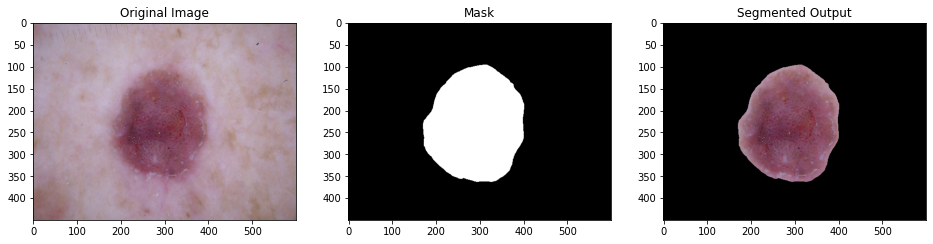

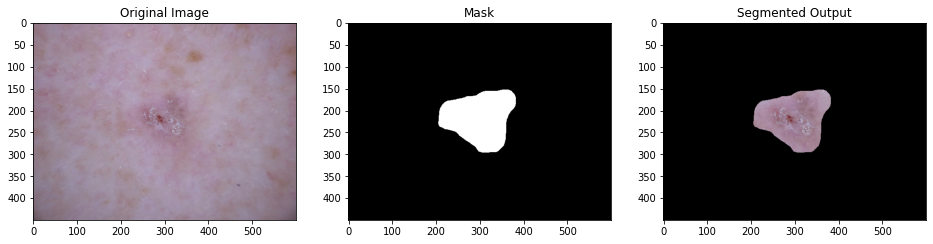

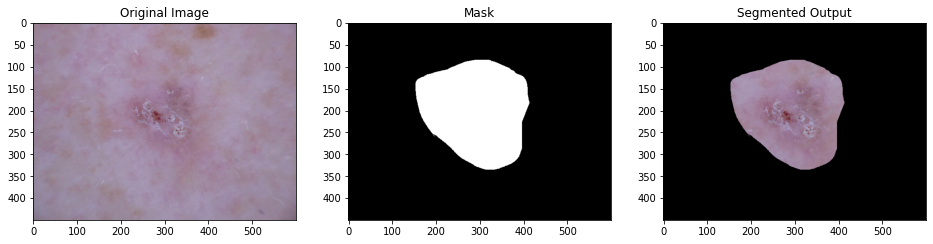

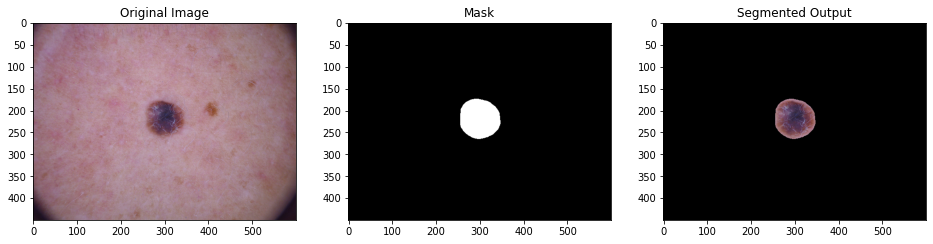

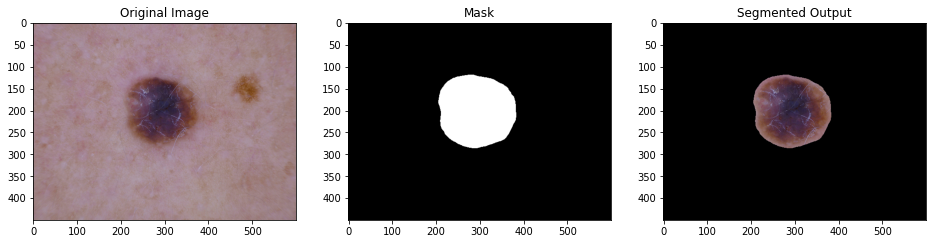

In [9]:
def applyMask(img, mask):
    res = cv2.bitwise_and(img, img, mask = mask)
    return res

def get_image_arr(i):
    img_index = skin_df[skin_df['image_id'] == i].index
    img_index = img_index[0]
    img_path = skin_df[skin_df['image_id'] == i]['image_path']
    img = img_path[img_index]
    img = np.array(Image.open(img))
    return img
    
def get_image_mask_arr(i):
    image_mask_id = f"{i}_segmentation"
    img_mask_index = skin_df[skin_df['image_mask_id'] == image_mask_id].index
    img_mask_index = img_mask_index[0]
    img_mask_path = skin_df[skin_df['image_mask_id'] == image_mask_id]['image_mask_path']
    img_mask = img_mask_path[img_mask_index]
    img_mask = np.array(Image.open(img_mask))//255
    if(img_mask[0][0] == 1):
        img_mask = (1 - img_mask)  
    return img_mask

for i in skin_df['image_id'][50:55]:
    img = get_image_arr(i)
    img_mask = get_image_mask_arr(i)        
    masked_img = applyMask(img, img_mask)

    plt.figure(figsize=(16,16))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(img_mask, plt.cm.binary_r)
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(masked_img)
    plt.title('Segmented Output')
    plt.show()

In [10]:
# getting list of random 500 images to train the model
images_500 = skin_df.sample(500)
image_path_500 = images_500['image_path']
image_mask_path_500 = images_500['image_mask_path']

In [11]:
image_path_500[:10]

9164    ../input/dataverse-ham10000/Dataverse/HAM10000...
7733    ../input/dataverse-ham10000/Dataverse/HAM10000...
9424    ../input/dataverse-ham10000/Dataverse/HAM10000...
1772    ../input/dataverse-ham10000/Dataverse/HAM10000...
537     ../input/dataverse-ham10000/Dataverse/HAM10000...
8204    ../input/dataverse-ham10000/Dataverse/HAM10000...
7071    ../input/dataverse-ham10000/Dataverse/HAM10000...
2138    ../input/dataverse-ham10000/Dataverse/HAM10000...
9787    ../input/dataverse-ham10000/Dataverse/HAM10000...
534     ../input/dataverse-ham10000/Dataverse/HAM10000...
Name: image_path, dtype: object

In [12]:
image_mask_path_500[:10]

9164    ../input/dataverse-ham10000/Dataverse/HAM10000...
7733    ../input/dataverse-ham10000/Dataverse/HAM10000...
9424    ../input/dataverse-ham10000/Dataverse/HAM10000...
1772    ../input/dataverse-ham10000/Dataverse/HAM10000...
537     ../input/dataverse-ham10000/Dataverse/HAM10000...
8204    ../input/dataverse-ham10000/Dataverse/HAM10000...
7071    ../input/dataverse-ham10000/Dataverse/HAM10000...
2138    ../input/dataverse-ham10000/Dataverse/HAM10000...
9787    ../input/dataverse-ham10000/Dataverse/HAM10000...
534     ../input/dataverse-ham10000/Dataverse/HAM10000...
Name: image_mask_path, dtype: object

In [21]:
X_train = np.array([np.array(Image.open(fname).resize((256, 192))) for fname in image_path_500])

In [22]:
X_train[0]

array([[[125, 112, 110],
        [128, 110, 113],
        [130, 118, 118],
        ...,
        [139, 130, 135],
        [138, 127, 135],
        [139, 129, 137]],

       [[130, 116, 116],
        [130, 118, 114],
        [132, 116, 113],
        ...,
        [141, 132, 137],
        [141, 132, 138],
        [141, 134, 140]],

       [[132, 119, 116],
        [130, 118, 110],
        [129, 114, 115],
        ...,
        [145, 134, 140],
        [144, 133, 141],
        [145, 136, 143]],

       ...,

       [[124, 109, 106],
        [125, 110, 107],
        [125, 112, 108],
        ...,
        [125, 109, 109],
        [127, 111, 113],
        [125, 109, 117]],

       [[122, 108, 106],
        [124, 112, 108],
        [126, 111, 106],
        ...,
        [126, 110, 113],
        [128, 112, 115],
        [126, 110, 118]],

       [[122, 108, 109],
        [122, 110, 109],
        [124, 108, 104],
        ...,
        [125, 108, 113],
        [125, 110, 112],
        [126, 111, 114]]

In [36]:
Y_train = []
for fname in image_mask_path_500:
    fname = np.array(Image.open(fname).resize((256, 192)))//255 
    if(fname[0][0] == 1):
        fname = (1 - fname) 
    Y_train.append(fname)
    
Y_train = np.array(Y_train)

In [37]:
Y_train[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [38]:
# Splitting the dataset into training set and test set to verify our model performance without any bias.
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

In [39]:
print("Length of the Full Set       : {}".format(len(X_train)))
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))

Length of the Full Set       : 500
Length of the Training Set   : 375
Length of the Test Set       : 125


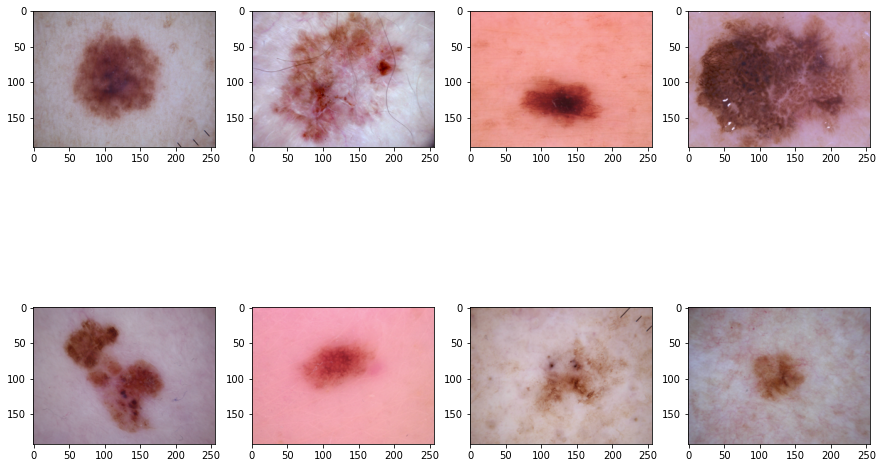

In [40]:
# Let's plot an image to see how the original images look.
plt.figure(figsize=(15,10))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()

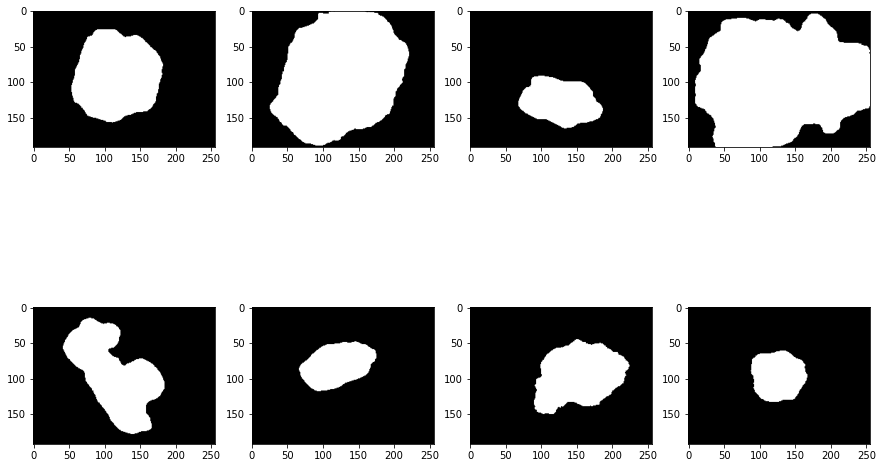

In [41]:
# Now let's see their corresponding masks.
plt.figure(figsize=(15,10))
plt.subplot(2,4,1)
plt.imshow(Y_train[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train[149], cmap = plt.cm.binary_r)
plt.show()

In [42]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [43]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [44]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [45]:
def img_augmentation(x_test, y_test):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [46]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

In [47]:
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

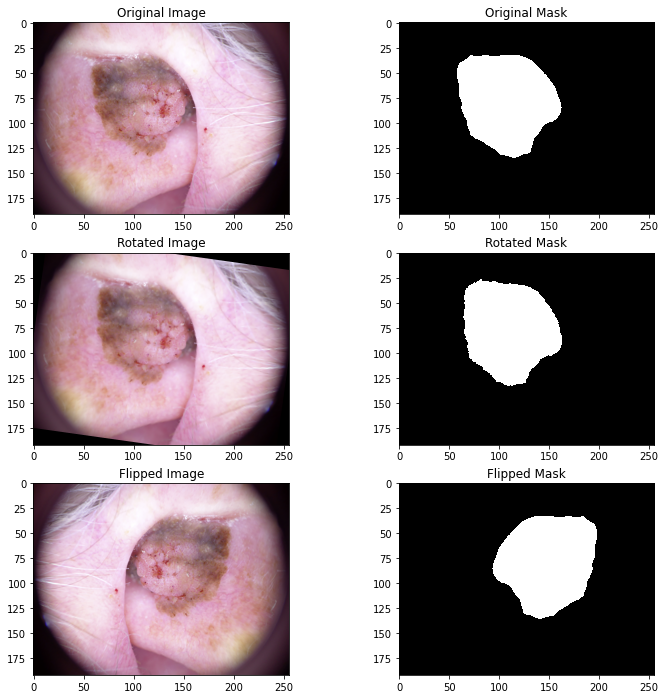

In [48]:
import random

img_num = random.randint(0, len(x_train))

plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [49]:
# For training Set
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])

In [50]:
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [51]:
print("Length of the Concatenated Training Set   : {}".format(len(x_train_full)))

Length of the Concatenated Training Set   : 1125


In [52]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.30, random_state = 101)

In [56]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 787
Length of the Test Set       : 125
Length of the Validation Set : 338


In [58]:
def unet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18, validation_data= (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

In [59]:
model, hist = unet(1, 'unet_1_epoch.h5')

2021-09-13 12:52:02.941800: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-13 12:52:02.945133: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-13 12:52:02.984070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-13 12:52:02.984821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-13 12:52:02.984906: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-13 12:52:03.029330: I tensorflow/stream_executor/platform/def

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 192, 256, 64)      1792      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 192, 256, 64)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 192, 256, 64)      36928     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 192, 256, 64)      0     

2021-09-13 12:52:05.719289: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-13 12:52:05.729593: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000134999 Hz
2021-09-13 12:52:08.969998: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-13 12:52:09.713009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-13 12:52:09.744387: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


44/44 [==============================] - 28s 416ms/step - loss: 0.6950 - iou: 0.6783 - dice_coef: 0.3706 - precision: 0.3482 - recall: 0.6352 - accuracy: 0.6094 - val_loss: 0.6365 - val_iou: 0.6929 - val_dice_coef: 0.3307 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7312


In [60]:
model, hist = unet(epochs_num= 50, savename= 'unet_50_epoch.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 192, 256, 64)      1792      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation_26 (Activation)   (None, 192, 256, 64)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 192, 256, 64)      36928     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 192, 256, 64)      256       
_________________________________________________________________
activation_27 (Activation)   (None, 192, 256, 64)      0   

In [61]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

44/44 [==============================] - 5s 106ms/step - loss: 0.1166 - iou: 0.9676 - dice_coef: 0.8143 - precision: 0.9629 - recall: 0.9442 - accuracy: 0.9770
________________________
IOU:       |   96.76  |
Dice Coef: |   81.43  |
Precision: |   96.29  |
Recall:    |   94.42  |
Accuracy:  |   97.70  |
Loss:      |   11.66  |
________________________

-------------On Test  Set--------------------------

7/7 [==============================] - 2s 213ms/step - loss: 0.2367 - iou: 0.9185 - dice_coef: 0.7297 - precision: 0.8785 - recall: 0.8083 - accuracy: 0.9186
________________________
IOU:       |   91.85  |
Dice Coef: |   72.97  |
Precision: |   87.85  |
Recall:    |   80.83  |
Accuracy:  |   91.86  |
Loss:      |   23.67  |
________________________

-------------On validation Set---------------------

19/19 [==============================] - 2s 105ms/step - loss: 0.1894 - iou

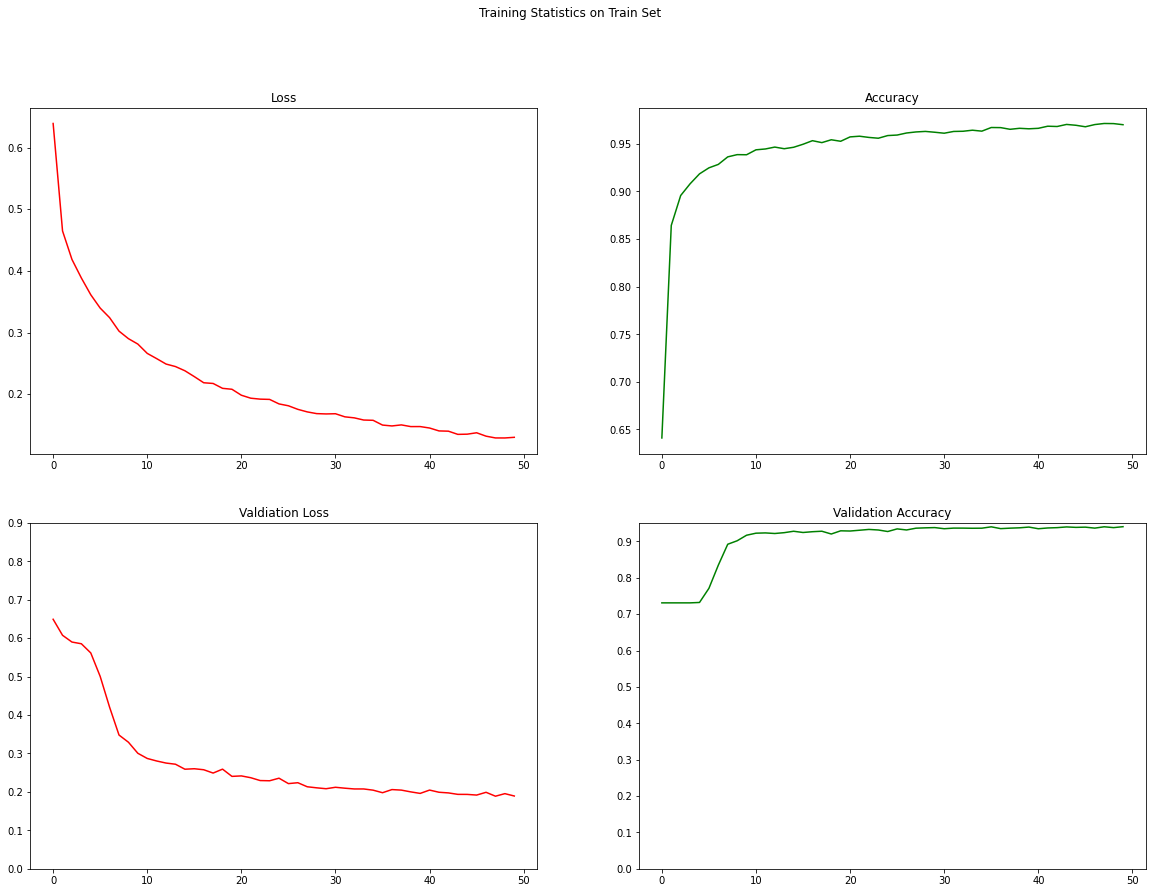

In [62]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

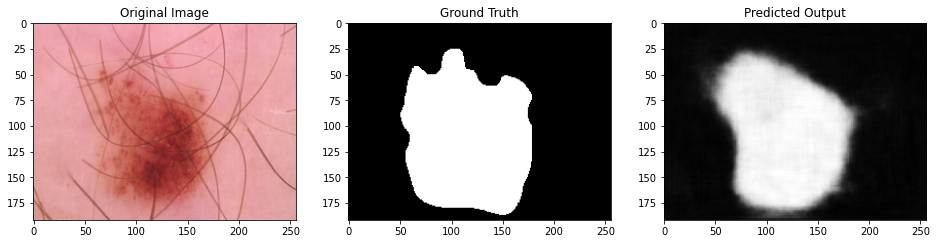

In [65]:
import random
img_num = random.randint(0, len(x_test))


img_pred = model.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

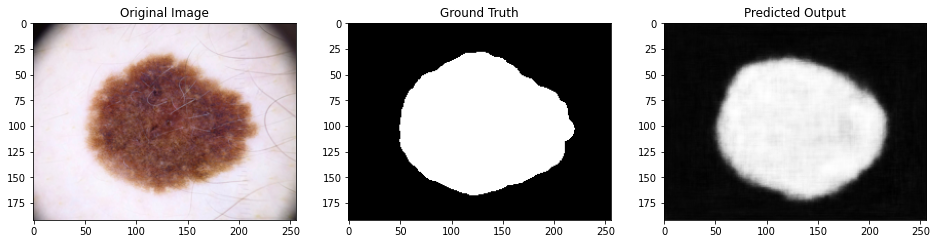

In [66]:
import random
img_num = random.randint(0, len(x_test))


img_pred = model.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

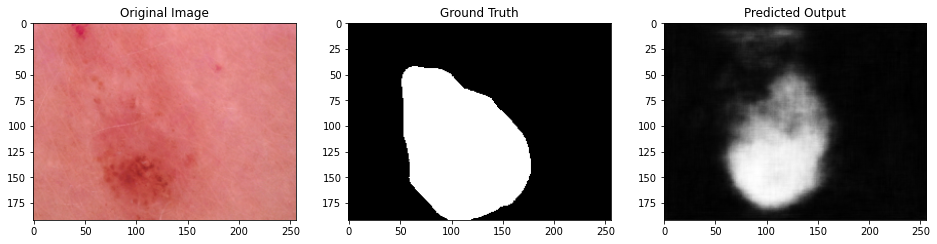

In [67]:
import random
img_num = random.randint(0, len(x_test))


img_pred = model.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

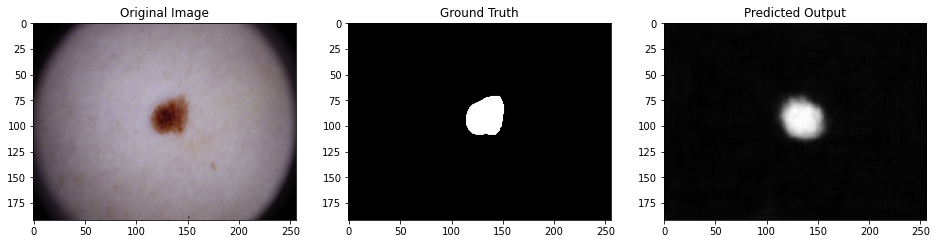

In [68]:
import random
img_num = random.randint(0, len(x_test))


img_pred = model.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

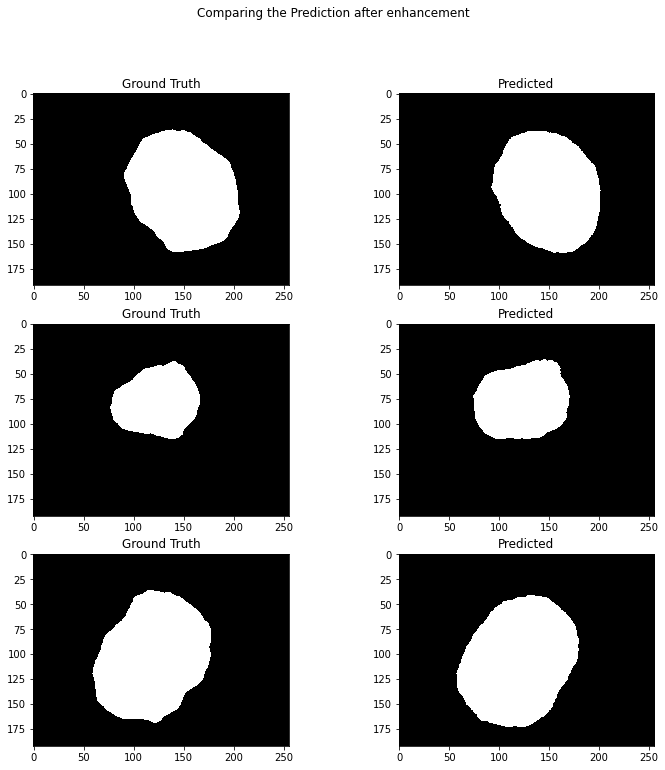

In [70]:
def enhance(img):
    sub = (model.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub



plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

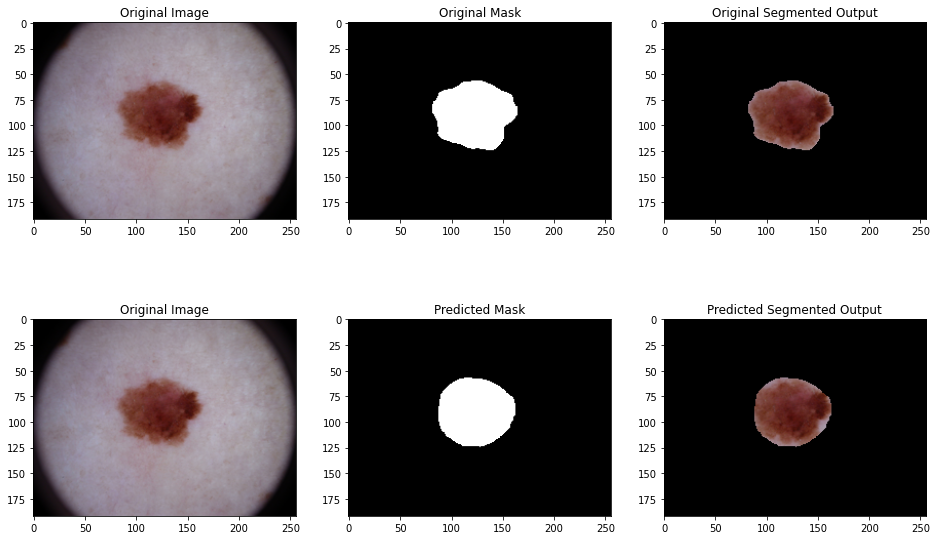

In [95]:
def applyPredictedMask(img_num):
    img = x_test[img_num]
    mask = np.array(enhance(img).reshape(192, 256), dtype=np.uint8)
    res = cv2.bitwise_and(img,img,mask = mask)
    return res

def applyMask(img, mask):
    res = cv2.bitwise_and(img, img, mask = mask)
    return res

img_num = random.randint(0, len(x_test))
pred_masked_img = applyPredictedMask(img_num)
masked_img = applyMask(x_test[img_num], y_test[img_num])
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(2,3,2)
plt.imshow(y_test[img_num],plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(2,3,3)
plt.imshow(masked_img, plt.cm.binary_r)
plt.title('Original Segmented Output')
plt.subplot(2,3,4)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(2,3,5)
plt.imshow(enhance(x_test[img_num]).reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Mask')
plt.subplot(2,3,6)
plt.imshow(pred_masked_img, plt.cm.binary_r)
plt.title('Predicted Segmented Output')
plt.show()